In [1]:
import pandas as pd
pd.set_option("display.max_columns", 100)
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
CSV_DATA = Path().cwd().parent.parent / "data/1_transformed/"

In [2]:
def plot_state_column(df:pd.DataFrame, column:str, color_by:str='segment_id',figsize=(15,3),
                       ylims:list[float]=None, units:str='none', show_mean:bool=True) -> None:
    _ = plt.figure(figsize=figsize)
    _ = plt.hlines(y=df[column].mean(), xmin=1, xmax=df['elapsed_time'].max(), colors='red', linestyles='dashed')
    _ = sns.lineplot(df, x='elapsed_time', y=column, hue=color_by, palette='hls', legend=False)
    _ = plt.grid()
    _ = plt.title(f'{column.upper()} Segments', fontsize=18)
    _ = plt.xlabel('Elapsed Time (seconds)', fontsize=14)
    _ = plt.ylabel(f'{column.upper()} ({units})', fontsize=14)
    
    if ylims is not None:
        _ = plt.ylim(ylims)

# 1. Load Ride Data

In [3]:
df = pd.read_csv(CSV_DATA / "0x66780269.csv")

In [4]:
# How many miles was this ride?
df['delta_dist_ft'].sum() / 5280

20.942177878102125

In [5]:
df.columns

Index(['time', 'ride_id', 'segment_id', 'elevation', 'latitude', 'longitude',
       'ambient_temp_C', 'heart_rate_bpm', 'cadence_rpm', 'is_original_row',
       'elapsed_time', 'delta_time', 'delta_dist_ft', 'heading', 'speed',
       'is_cruising', 'delta_ele_ft', 'grade', 'grade_saturated',
       'elapsed_ascent', 'elapsed_descent', 'elapsed_elevation',
       'filt_ambient_temp_C', 'filt_heart_rate_bpm', 'filt_cadence_rpm',
       'filt_speed', 'filt_grade', 'filt_grade_saturated', 'inst_power'],
      dtype='object')

In [6]:
cols_of_interest = ['time','segment_id','elapsed_time','delta_time','delta_dist_ft','speed','grade_saturated','filt_speed','filt_grade_saturated','inst_power',]
df = df.loc[:,cols_of_interest].copy()
df.head()

,time,segment_id,elapsed_time,delta_time,delta_dist_ft,speed,grade_saturated,filt_speed,filt_grade_saturated,inst_power
0,2024-06-23 11:09:29+00:00,0.0,1.0,1.0,0.000000,0.000000,0.0,0.063616,0.0,0.164611
1,2024-06-23 11:09:30+00:00,0.0,2.0,1.0,0.000000,0.000000,0.0,0.081516,0.0,0.210933
2,2024-06-23 11:09:31+00:00,0.0,3.0,1.0,0.364813,0.248736,0.0,0.099685,0.0,0.257956
3,2024-06-23 11:09:32+00:00,0.0,4.0,1.0,0.000000,0.000000,0.0,0.116345,0.0,0.301078
4,2024-06-23 11:09:33+00:00,0.0,5.0,1.0,0.364813,0.248736,0.0,0.129865,0.0,0.336075


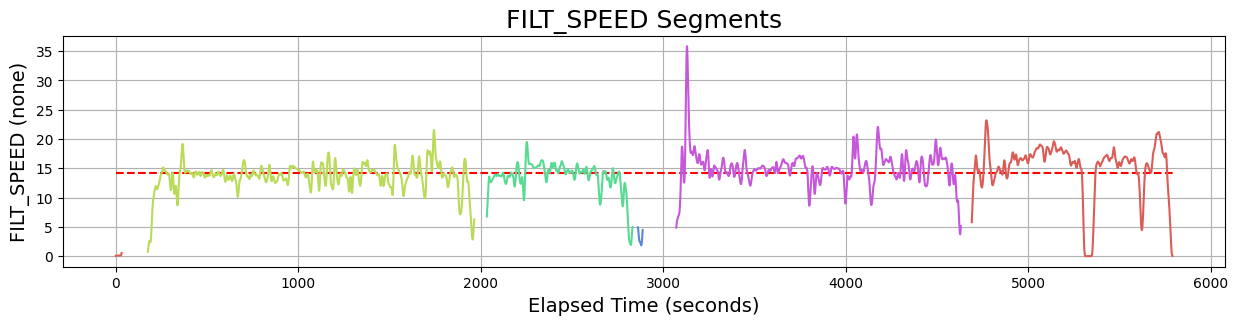

In [7]:
plot_state_column(df, 'filt_speed')

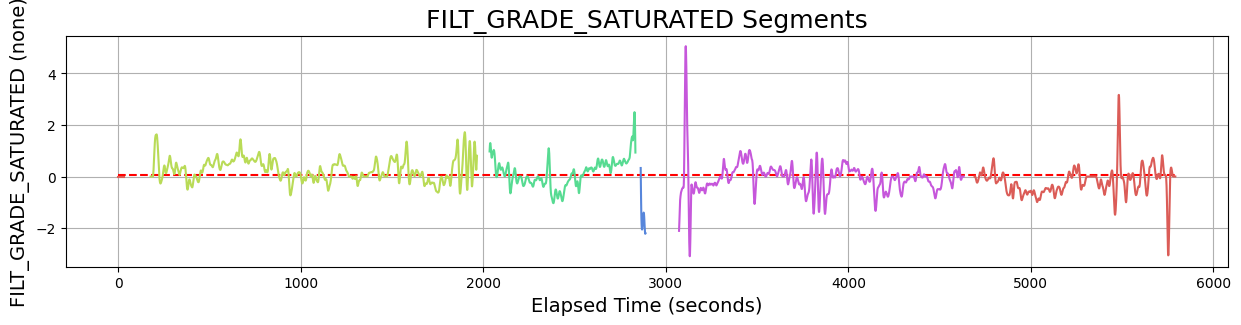

In [8]:
plot_state_column(df, 'filt_grade_saturated')

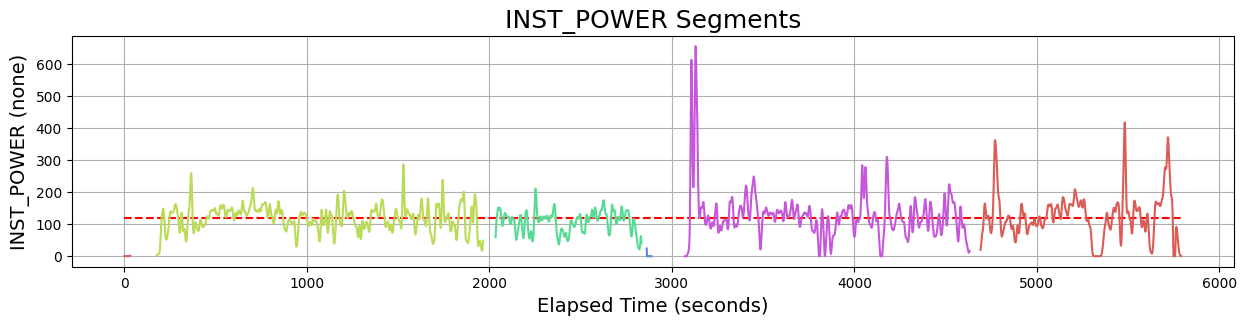

In [9]:
plot_state_column(df, 'inst_power')

In [37]:
def calculate_power_curve(df: pd.DataFrame, agg_over_windows:str='max'):
    # Create a set of rolling windows to calculate an aggregation over avg(inst_powers[within_window])
    # Note: the outer aggregation can be MAX, AVG or some other more complicated aggregation (ex: geometric mean)
    rolling_windows = [4, 5, 10, 20, 30, 60, # seconds
                        2*60, 3*60, 4*60, 5*60, 6*60, 10*60, 20*60, 30*60, 40*60, # minutes
                        60*60, 2*60*60, 3*60*60, 4*60*60, 5*60*60, 6*60*60, 7*60*60] # hours
    agg_over_window_funcs = {'max':max, 'mean':np.mean}

    # Calculate the moving time of the ride. We should not calculate the peak power for a window that is longer than this value since it is ill defined
    # Note: moving time =/= elapsed time since the latter accounts for stops and food breaks
    ride_moving_time = df['delta_time'].sum() 

    # Initialize a list to store the peak powers per window
    window_peak_powers = []

    for rwindow in rolling_windows:
        rolling_avg_inst_power = df[['inst_power']].rolling(rwindow, min_periods=rwindow).mean().dropna()
        if rolling_avg_inst_power.shape[0]==0: # all values were np.nan, hence the window is too large for the ride data
            peak_power = np.nan
        else:
            peak_power = agg_over_window_funcs[agg_over_windows](rolling_avg_inst_power.values[0])
        window_peak_powers.append({'time_window':rwindow, 'peak_avg_power':peak_power})
    
    return pd.DataFrame(window_peak_powers)

In [38]:
calculate_power_curve(df=df)

,time_window,peak_avg_power
0,4,0.233645
1,5,0.254131
2,10,0.304326
3,20,0.295307
4,30,0.336098
5,60,11.421437
6,120,59.574463
7,180,81.205565
8,240,91.319686
9,300,92.118559


In [33]:
df[['time','inst_power']].rolling(2*3600, on='time', min_periods=3600).mean().tail(5)

,time,inst_power
5305,2024-06-23 12:45:55+00:00,119.697242
5306,2024-06-23 12:45:56+00:00,119.674806
5307,2024-06-23 12:45:57+00:00,119.652331
5308,2024-06-23 12:45:58+00:00,119.629837
5309,2024-06-23 12:45:59+00:00,119.607334


In [34]:
df[['inst_power']].rolling(2*3600, min_periods=3600).mean().tail(5)

,inst_power
5305,119.697242
5306,119.674806
5307,119.652331
5308,119.629837
5309,119.607334
